# To run this script, it must be in the same floder with all the dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed  # For parallel computing
from tqdm import tqdm                 # For Display the progress
from simulated_data import*
from plotnine import*
# from stochastic_epidemic_model import seir_model_const, seir_model_var, stochastic_model_covid
from particle_filter import Kernel_Smoothing_Filter
from trace_plot import trace_smc, trace_smc_covid, plot_smc, plot_smc_covid

In [2]:
# pip install plotnine 

## Sequential Monte Carlo for state and Parameters estimation

- The following codes generate the dataset and SMC code itself using kernel density estimation
- The SMC code is apply in a context of infectious diseases.

### Import data COVID-19  Ireland

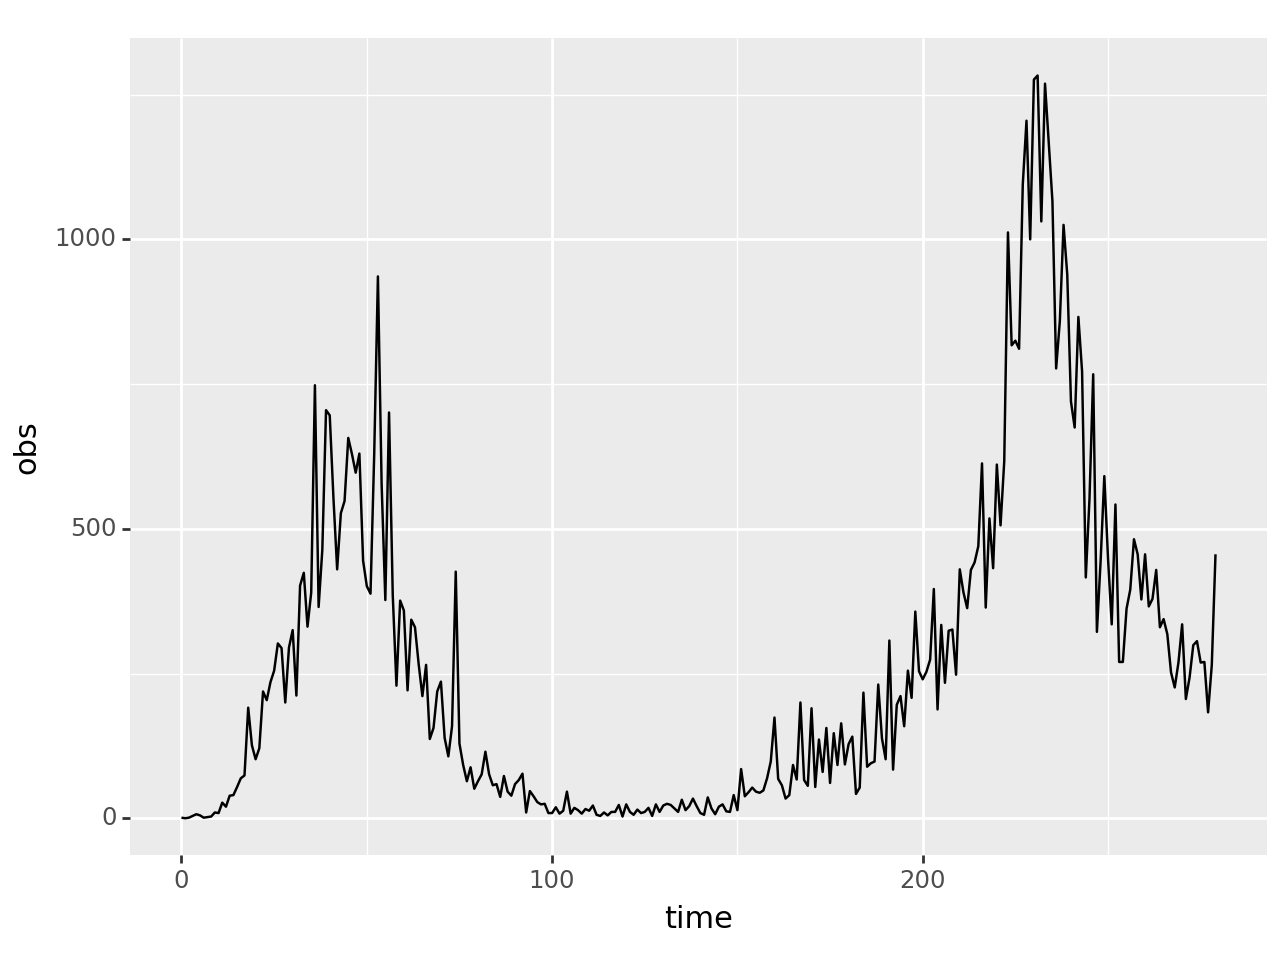

<Figure Size: (640 x 480)>

In [3]:

# Assuming the uploaded file is named "COVID-19_HPSC_Detailed_Statistics_Profile.csv"
file_path = r"COVID-19_HPSC_Detailed_Statistics_Profile.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Assuming df is your original DataFrame
d = df[['Date', 'ConfirmedCovidCases', 'ConfirmedCovidDeaths', 'HospitalisedCovidCases']].fillna(0)

# Create a column of cumulative deaths
d['Death'] = d['ConfirmedCovidDeaths'].cumsum()

# Restrict the observations to 280 days
days = 280
data = d.iloc[:days].copy()  # use iloc to avoid potential slicing issues

# Add a 'time' column
data['time'] = np.arange(0, days)

# Rename the 'ConfirmedCovidCases' column to 'obs' (avoid inplace=True)
data = data.rename(columns={'ConfirmedCovidCases': 'obs'})

# Plot using ggplot
(ggplot(data) +
 aes(x='time', y='obs') +
 geom_line()
)


In [4]:
###############################################
#### This data is not use in the algorthim ####
###############################################

# Define number of forecasting days
projectionday = 7

# Assuming df is your DataFrame containing the time series data and 'Date' is the column containing the dates
d2 = d.iloc[:days+projectionday].copy()  # Use .iloc to safely slice rows

# Convert 'Date' column to datetime if it's not already in the correct format
d2['Date'] = pd.to_datetime(d2['Date'], errors='coerce')  # Use errors='coerce' to handle invalid dates


### Define your SEIR model

In [5]:

#Logit transform for the death probability
def logit(p):
    return np.log(p/(1-p))
def invlogit(p):
    return np.exp(p)/(1+np.exp(p))

# This model with with beta following geometric random walk can track multiple wave epidemic
def stochastic_model_covid(y, theta, theta_names, dt=1):
    """
    Discrete-time stochastic compartmental model for COVID-19 Ireland.

    Parameters:
    - y: Vector of compartments [S, E, Ips, Ias, Isi, Ist, Ipi, Isn, R, D, NI, B, d]
     (We ue D and NI variables to link with the observations)
    - parameters: Set of parameters [vb_2, v_d]
     
    Returns:
    - y_next: Updated vector of compartments [S, E, Ips, Ias, Isi, Ist, Ipi, Isn, R, D, NI, B, d]
    """

    # Unpack variables
    S, E, Ips, Ias, Isi, Ist, Ipi, Isn, R, CD, NI, B, d = y
    N = S + E + Ips + Ias + Isi + Ist + Ipi + Isn + R 

    # Convert d from logit to probability
    d = logit(d)

    # Unpack parameters
    param= dict(zip(theta_names, theta))
    

    # Model parameters from table
    r_as = 0.55
    r_si = 0.05
    r_pi = 0.05
    tau_c = 5.85
    tau_l = 4.9
    tau_d = 7
    tau_r = 3.52
    f_as = 0.2
    f_si = 0.1
    f_st = 0.8

    # Probabilities of transitions using binomial distributions
    P_Y1 = 1 - np.exp(-B * (Ips + r_as * Ias + r_si * Isi + Ist + r_pi * Ipi + Isn) * dt / N)
    P_Y2 = 1 - np.exp(-1 / tau_l * dt)
    P_Y3 = 1 - f_as
    P_Y4 = 1 - np.exp(-1 / (tau_c - tau_l) * dt)
    P_Y5 = f_si
    P_Y6 = f_st
    P_Y7 = 1 - np.exp(-1 / tau_d * dt)
    P_Y8 = 1 - np.exp(-1 / (tau_d - tau_c + tau_l) * dt)
    P_Y9 = 1 - np.exp(-1 / tau_r * dt)
    P_Y10 = 1 - np.exp(-1 / (tau_d - tau_c + tau_l - tau_r) * dt)
    P_Y11 = 1 - np.exp(-1 / (tau_d - tau_c + tau_l) * dt)

    # Binomial distributions for transitions
    Y1 = np.random.binomial(S, P_Y1)
    Y2 = np.random.binomial(E, P_Y2)
    Y3 = np.random.binomial(Y2, P_Y3)
    Y4 = np.random.binomial(Ips, P_Y4)
    Y5 = np.random.binomial(Y4, P_Y5)
    Y6 = np.random.binomial(Y4, P_Y6)
    Y7 = np.random.binomial(Ias, P_Y7)
    Y8 = np.random.binomial(Isi, P_Y8)
    Y9 = np.random.binomial(Ist, P_Y9)
    Y10 = np.random.binomial(Ipi, P_Y10)
    Y11 = np.random.binomial(Isn, P_Y11)

    # Update the compartments
    S -= Y1
    E += Y1 - Y2
    Ips += Y3 - Y4
    Ias += Y2 - Y3 - Y7
    Isi += Y5 - Y8
    Ist += Y6 - Y9
    Ipi += Y9 - Y10
    Isn += Y4 - Y5 - Y6 - Y11
    R += Y7 + Y8 + Y10 + Y11
    CD += np.random.binomial(R, invlogit(d))
    NI = Y9

    # Update parameters B and d with stochastic variation
    B = B * np.exp(param['nu_beta_2'] ** 0.5 * np.random.normal(0, 1) * dt)
    d = invlogit(d + param['nu_d_2'] ** 0.5 * np.random.normal(0, 1) * dt)

    # Ensure all compartments are non-negative
    y_next = [max(0, compartment) for compartment in [S, E, Ips, Ias, Isi, Ist, Ipi, Isn, R, CD, NI, B, d]]

    return y_next


## Run Kernel Density Particle Filter

### <span style="color:red">**Important Note**</span>: We have added the cumulative data in the `compute_log_weight` in the `weight_processing.py` file. Modify it if you don't have this data.


In [6]:
N_pop=4965439
Ips_0_min =15
Ips_0_max = 100
E_0 =1
S_0_min = N_pop-Ips_0_max-E_0
S_0_max = N_pop-Ips_0_min-E_0
state_info = {
    'S': {'prior': [S_0_min, S_0_max, 0, 0, 'uniform']},  # Susceptible: fixed
    'E': {'prior': [E_0, E_0, 0, 0, 'uniform']},  # Exposed: uniform
    'Ips': {'prior': [Ips_0_min, Ips_0_max, 0, 0, 'uniform']},  # Pre-symptomatic: uniform
    'Ias': {'prior': [0, 0, 0, 0, 'uniform']},  # Asymptomatic: uniform
    'Isi': {'prior': [0, 0, 0, 0, 'uniform']},  # Symptomatic isolated: uniform
    'Ist': {'prior': [0, 0, 0, 0, 'uniform']},  # Symptomatic tested: uniform
    'Ipi': {'prior': [0, 0, 0, 0, 'uniform']},  # Post-symptomatic isolated: uniform
    'Isn': {'prior': [0, 0, 0, 0, 'uniform']},  # Symptomatic not isolated: uniform
    'R': {'prior': [0, 0, 0, 0, 'uniform']},  # Recovered: uniform
    'CD': {'prior': [0, 0, 0, 0, 'uniform']},  # cummulative death: uniform
    'NI': {'prior': [0, 0, 0,0, 'uniform']},    # Newly infected: uniform
    'B': {'prior': [0.7, 0.8, 0, 0, 'uniform']},  # Transmission rate: uniform
    'd': {'prior': [0.001, 0.002, 0,0,'uniform']} # death rate: uniform
}

theta_info = {
    'nu_beta_2':  {'prior': [80,0.02,0,0, 'invgamma']},  # square Variance for transmission rate
     'nu_d_2':{'prior': [80,0.01,0,0, 'invgamma']},    # square Variance for death rate
    'phi':{'prior': [30,0.2,0,0, 'invgamma']}  # Overdisperssion
}



# Run Particle Filter
results_filter = Kernel_Smoothing_Filter(
    model=stochastic_model_covid, 
    initial_state_info=state_info, 
    initial_theta_info=theta_info,  
    observed_data=data, 
    num_particles=5000, 
    population_size=4965439, 
    resampling_method='stratified', 
    observation_distribution='normal_approx_negative_binomial',
    forecast_days=7, 
    show_progress=True
)

print("Marginal log_likelihood=", results_filter['margLogLike'])


Particle Filter Progress: 100%|███████████████| 287/287 [41:35<00:00,  8.69s/it]

Marginal log_likelihood= -2743.005457189272


## IV.2-  Plot the solution

In [7]:
### We have to compute the effective reproduction number using the filtering estimate
### of the transmission rate beta
def trace_smc_covid(Traject):
    matrix_dict = {}
    stateName = list(Traject[0].columns[1:])  # Assuming Traject is a list of DataFrames with state variables
    # Iterate through each state name
    for state in stateName:
        # Extract matrices for each state from all dataframes
        state_matrices = [df[state].values.reshape(1, -1) for df in Traject]
        # Concatenate matrices horizontally
        combined_matrix = np.concatenate(state_matrices, axis=0)
        # Reshape the combined matrix based on the shape of the original dataframe
        reshaped_matrix = combined_matrix.reshape(-1, Traject[0].shape[0])
        # Store the reshaped matrix in the dictionary with state name as the key
        matrix_dict[state] = reshaped_matrix
    # Calculate variables from the model parameters
    # Model parameters from table in the paper
    r_as = 0.55
    r_si = 0.05
    r_pi = 0.05
    tau_c = 5.85
    tau_l = 4.9
    tau_d = 7
    tau_r = 3.52
    f_as = 0.2
    f_si = 0.1
    f_st = 0.8
    Npop = 4965439

    # Calculate Rt using the formula provided in the paper
    # you could modify it to suit your model (eg., Reff =beta/gamma *S/N for a simple SEIR model)
    # For the reproduction number do not include the proportion of suceptible S/N
    Rt = matrix_dict['B'] * ((f_as - 1) * ((r_si - 1) * f_si * (tau_c - tau_l) + (r_pi - 1) * f_st * (tau_c - tau_l + tau_r)) \
                             + tau_d * (f_as * (r_as - r_si * f_si - r_pi * f_st + f_si + f_st - 1) \
                                        + (r_si - 1) * f_si + (r_pi - 1) * f_st + 1)) \
         * matrix_dict['S'] / Npop
    # Add Rt to the matrix_dict
    matrix_dict['Rt'] = Rt
    return matrix_dict

Plot Trajectories

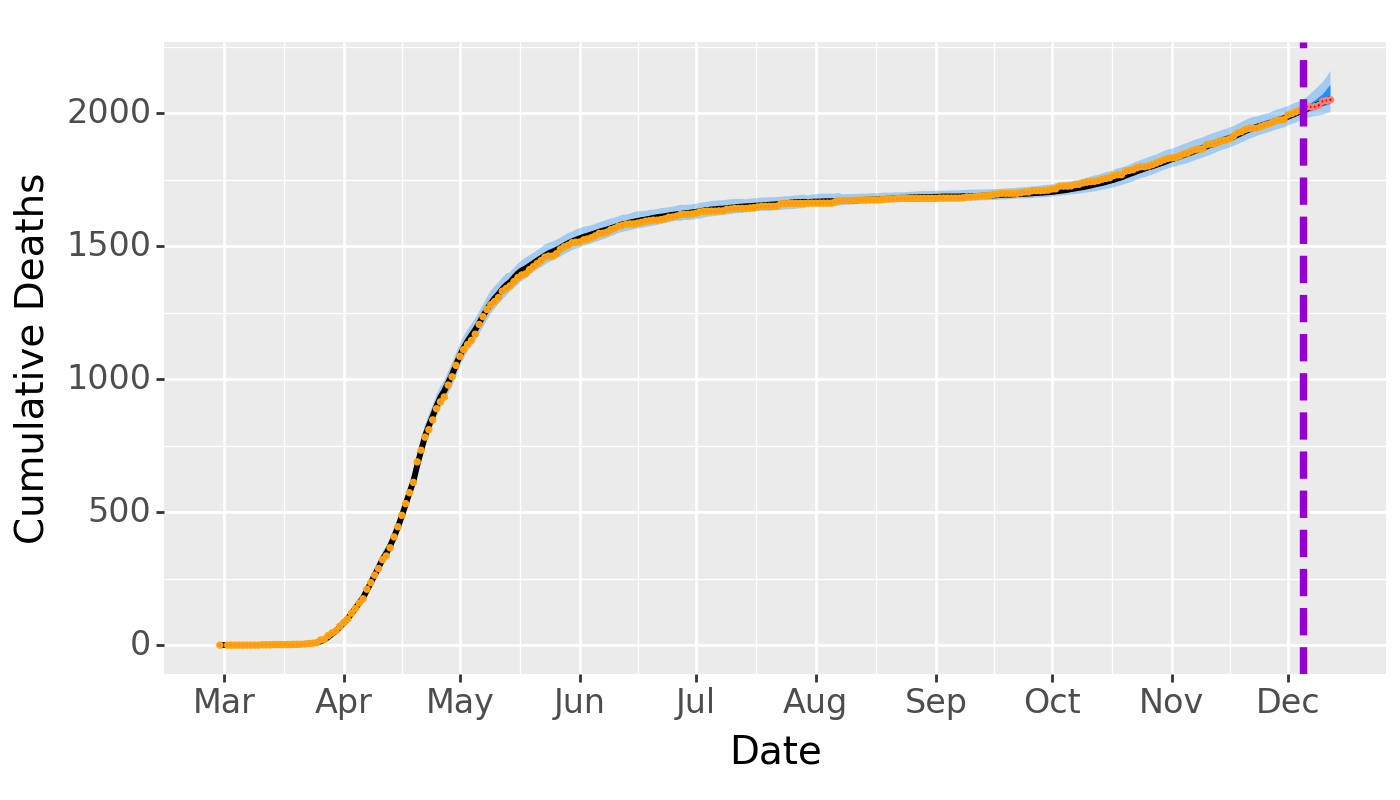

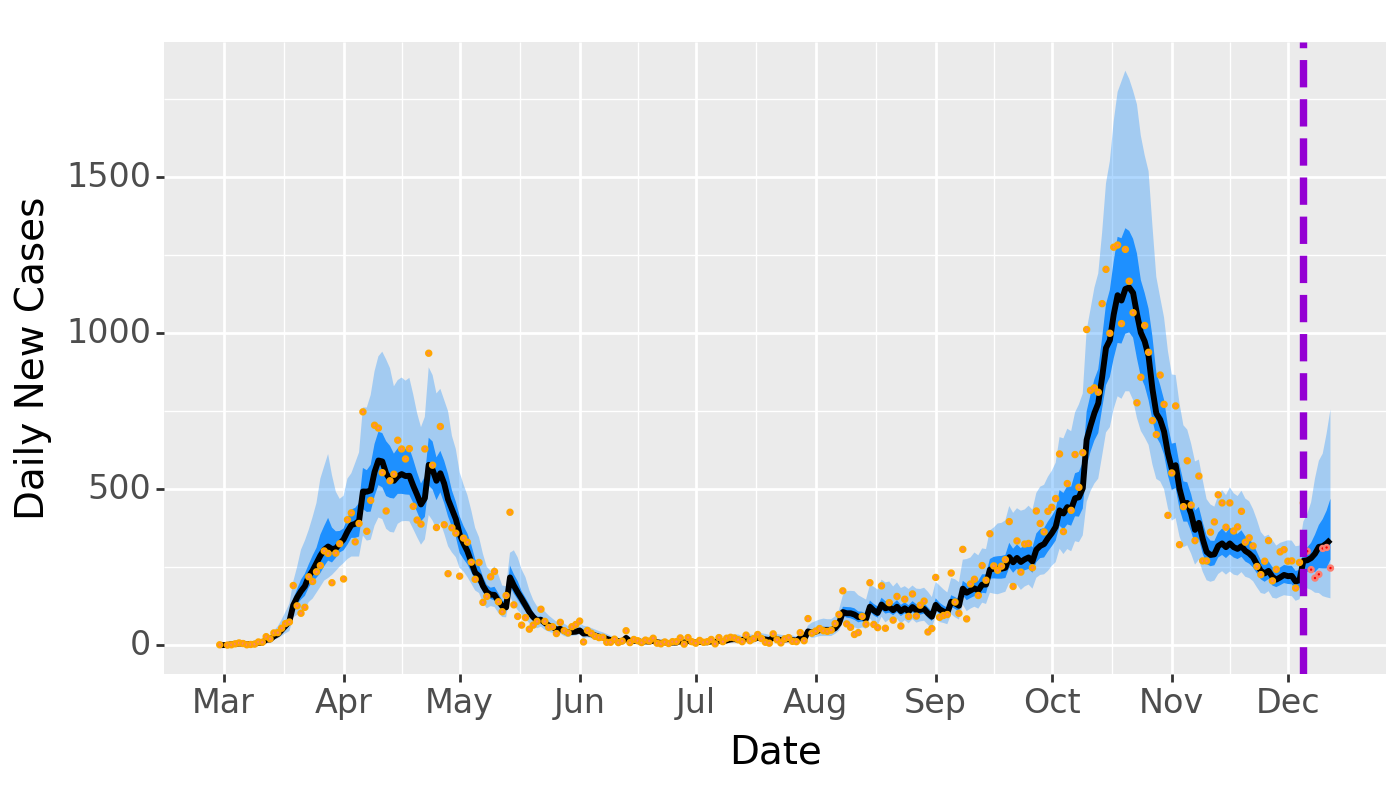

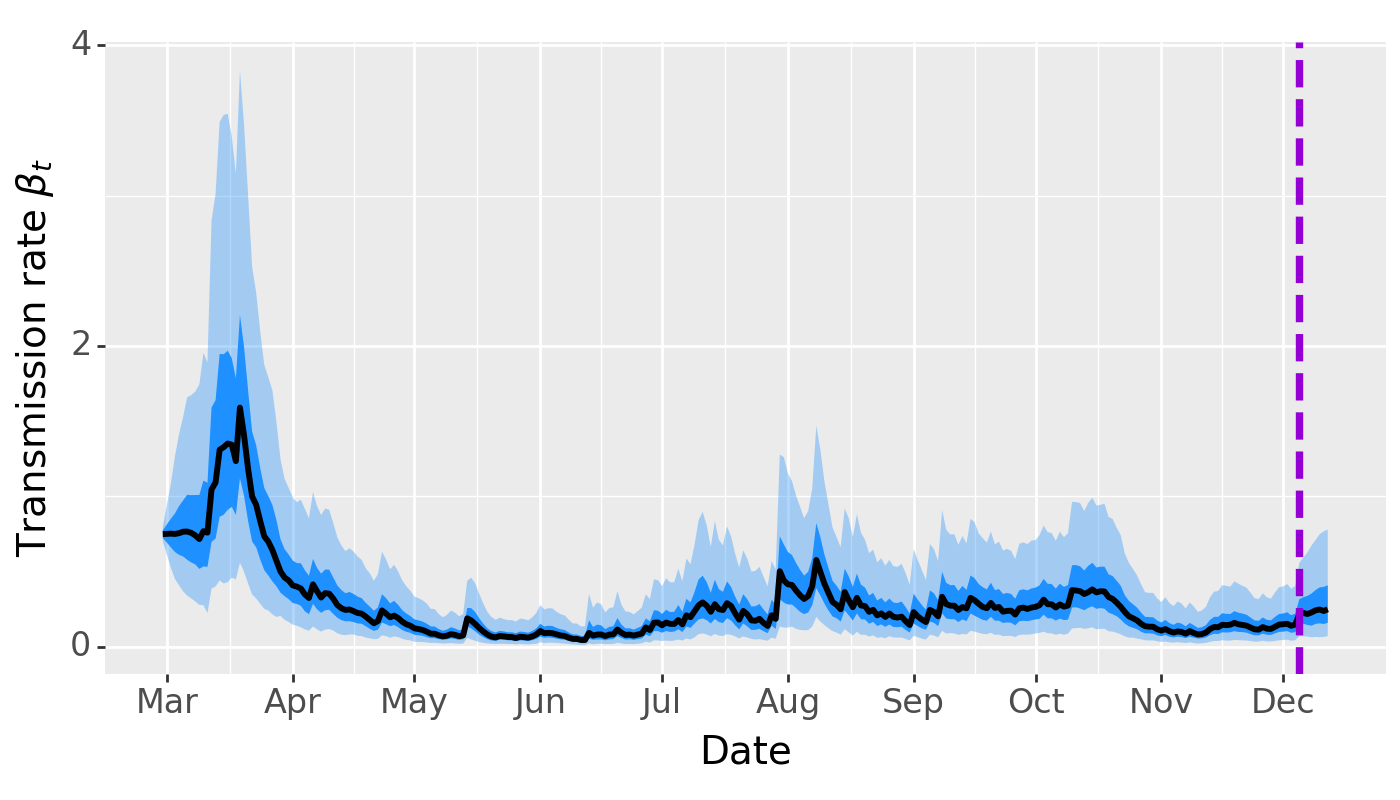

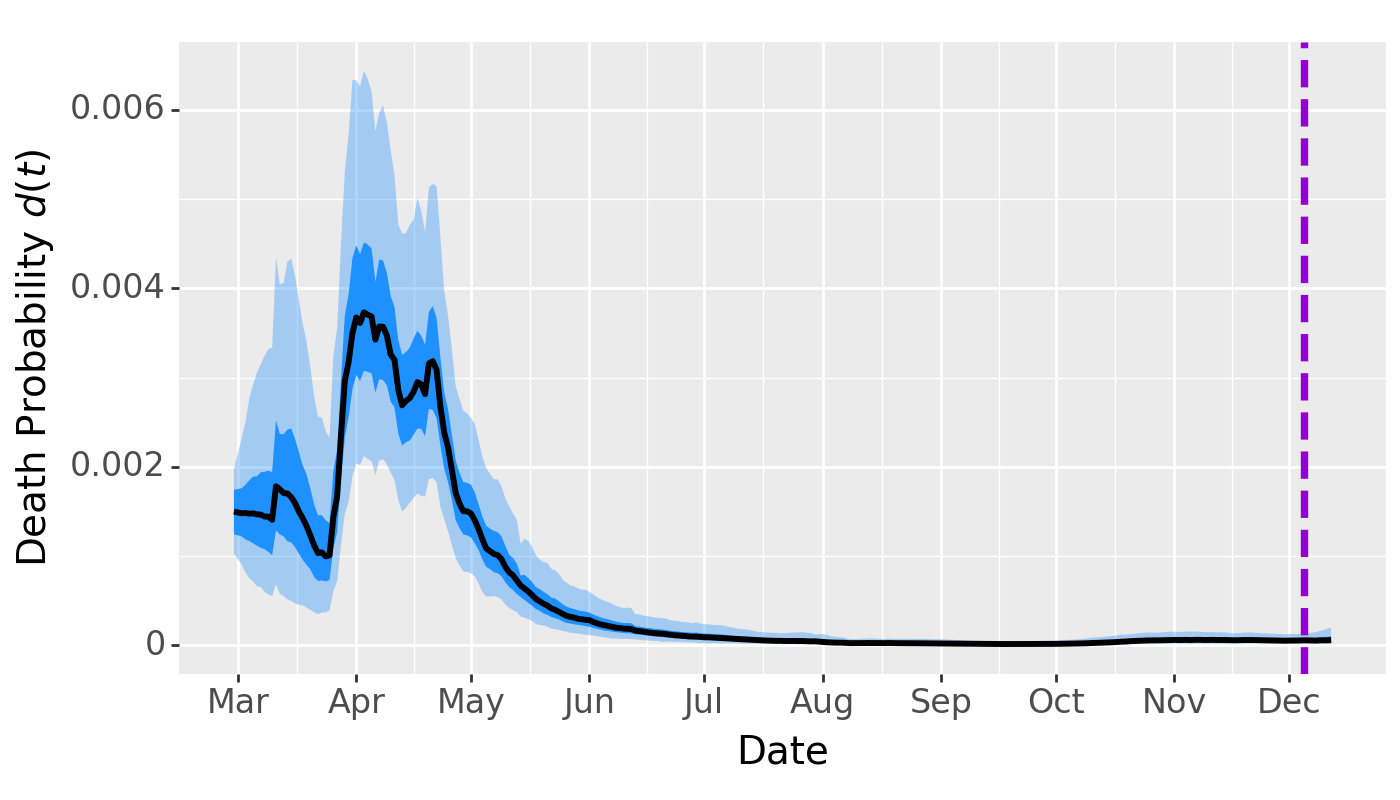

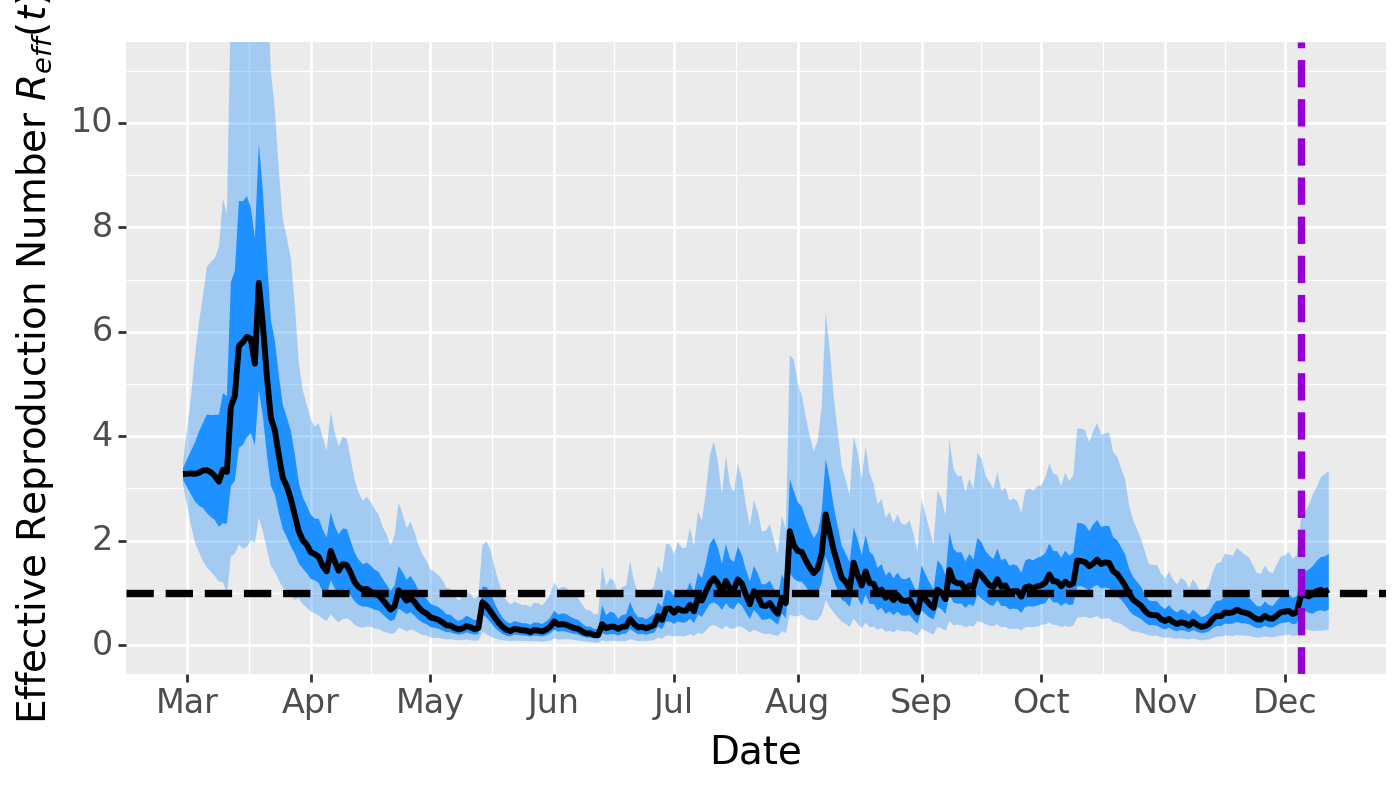

In [8]:

trajParticles1=results_filter['trajState']
matrix_dict=trace_smc_covid(trajParticles1)

for (state, matrix) in matrix_dict.items():
    
    if state == 'CD':
        p =  plot_smc_covid(matrix,d2['Date'] ) # use plot_smc(matrix, CI_50=False, CI_95=False) if you don't want the 50% or 95% CI to appear 
        p +=geom_point(aes(x=d2['Date'][:days], y=d2['Death'][:days]),fill='salmon', color='orange', size=0.5)
        p +=geom_point(aes(x=d2['Date'][days:], y=d2['Death'][days:]),fill='red', color='salmon', size=0.5)
        p +=geom_vline(xintercept=d2['Date'][days-1], color='darkviolet', linetype='dashed', size=1.5)
        # p+=scale_y_continuous(breaks=range(0, 6000, 1000))
        p += ylab("Cumulative Deaths") 
        p += xlab("Date")
        p += theme(figure_size=(7,4))
        print(p)
    
    elif state == 'NI':
        p =  plot_smc_covid(matrix,d2['Date'] ) # use plot_smc(matrix, CI_50=False, CI_95=False) if you don't want the 50% or 95% CI to appear 
        p +=geom_point(aes(x=d2['Date'][:days], y=d2['ConfirmedCovidCases'][:days]), fill='salmon', color='orange', size=0.5)
        p +=geom_point(aes(x=d2['Date'][days:], y=d2['ConfirmedCovidCases'][days:]), fill='red', color='salmon', size=0.5)
        p +=geom_vline(xintercept=d2['Date'][days-1], color='darkviolet', linetype='dashed', size=1.5)
        # p+=scale_y_continuous(breaks=range(0, 15000, 3000))
        p += ylab("Daily New Cases") 
        p += xlab("Date")
        p += theme(figure_size=(7,4))
        print(p)

    elif state == 'd':
        p =  plot_smc_covid(matrix,d2['Date']) # use plot_smc(matrix, CI_50=False, CI_95=False) if you don't want the 50% or 95% CI to appear 
        p +=geom_vline(xintercept=d2['Date'][days-1], color='darkviolet', linetype='dashed', size=1.5)
        p += ylab(r'Death Probability $d(t)$')
        p += xlab("Date")
        p += theme(figure_size=(7,4))
        print(p)  
        
    elif state == 'Rt':
    
        p =  plot_smc_covid(matrix,d2['Date']) # use plot_smc(matrix, CI_50=False, CI_95=False) if you don't want the 50% or 95% CI to appear 
        p +=geom_hline(yintercept=1, color='k', linetype='dashed', size=1.5)
        p +=geom_vline(xintercept=d2['Date'][days-1], color='darkviolet', linetype='dashed', size=1.5)
        p+=scale_y_continuous(breaks=range(0, 12, 2))
        p +=  coord_cartesian(ylim=(0, 11))
        p += ylab(r'Effective Reproduction Number $R_{eff}(t)$') 
        p += xlab("Date")
        p += theme(figure_size=(7,4))
        print(p)
        
    elif state == 'B':
        p =  plot_smc_covid(matrix,d2['Date']) # use plot_smc(matrix,d2['Date'], CI_95=False) if you don't want the 95% CI to appear
        p +=geom_vline(xintercept=d2['Date'][days-1], color='darkviolet', linetype='dashed', size=1.5)
        p+=scale_y_continuous(breaks=range(0, 12, 2))
        p += ylab(r'Transmission rate $\beta_t$') 
        p += xlab("Date")
        p += theme(figure_size=(7,4))
        print(p) 

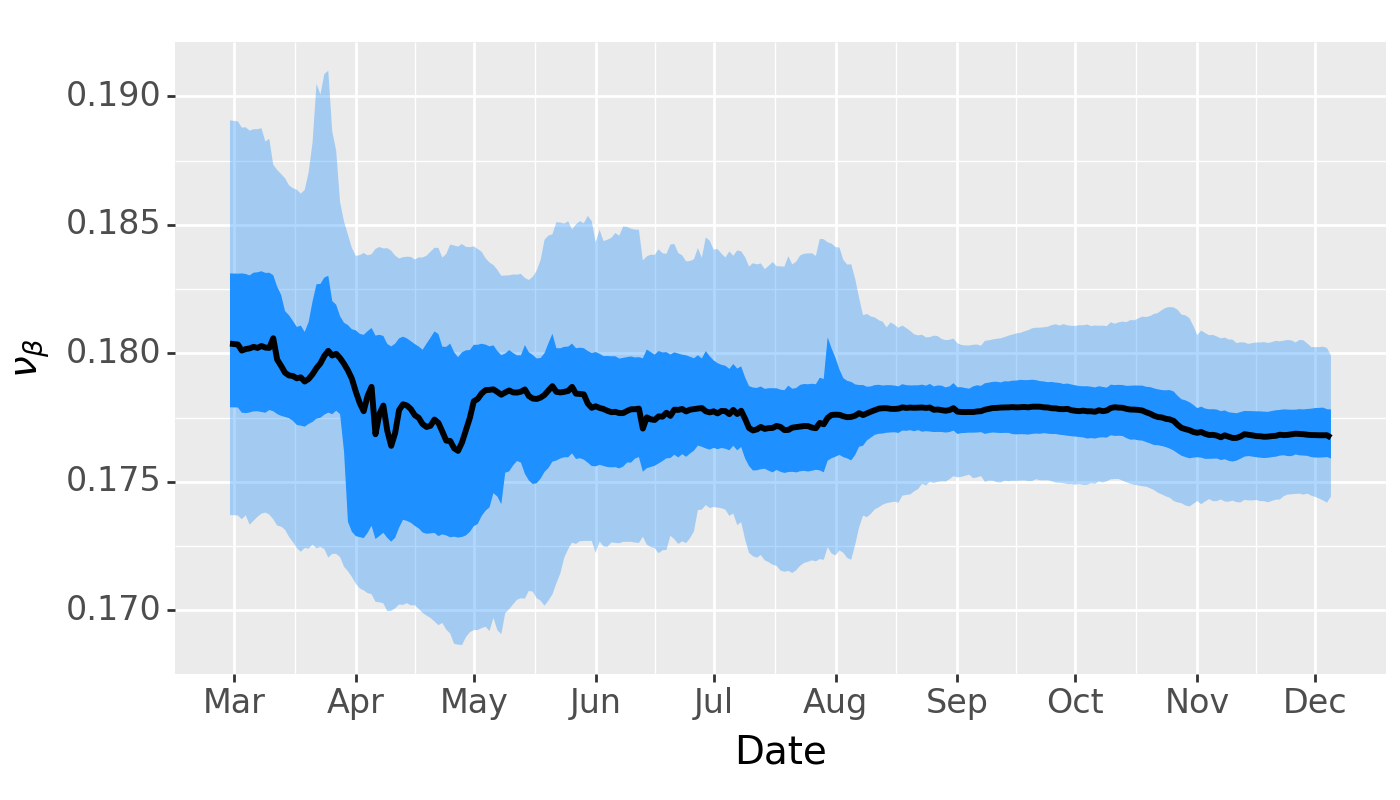


95 CI [0.17442847 0.17991775]
median 0.17671691033954354
mean 0.1768978426986259
std 0.0013867573236190196


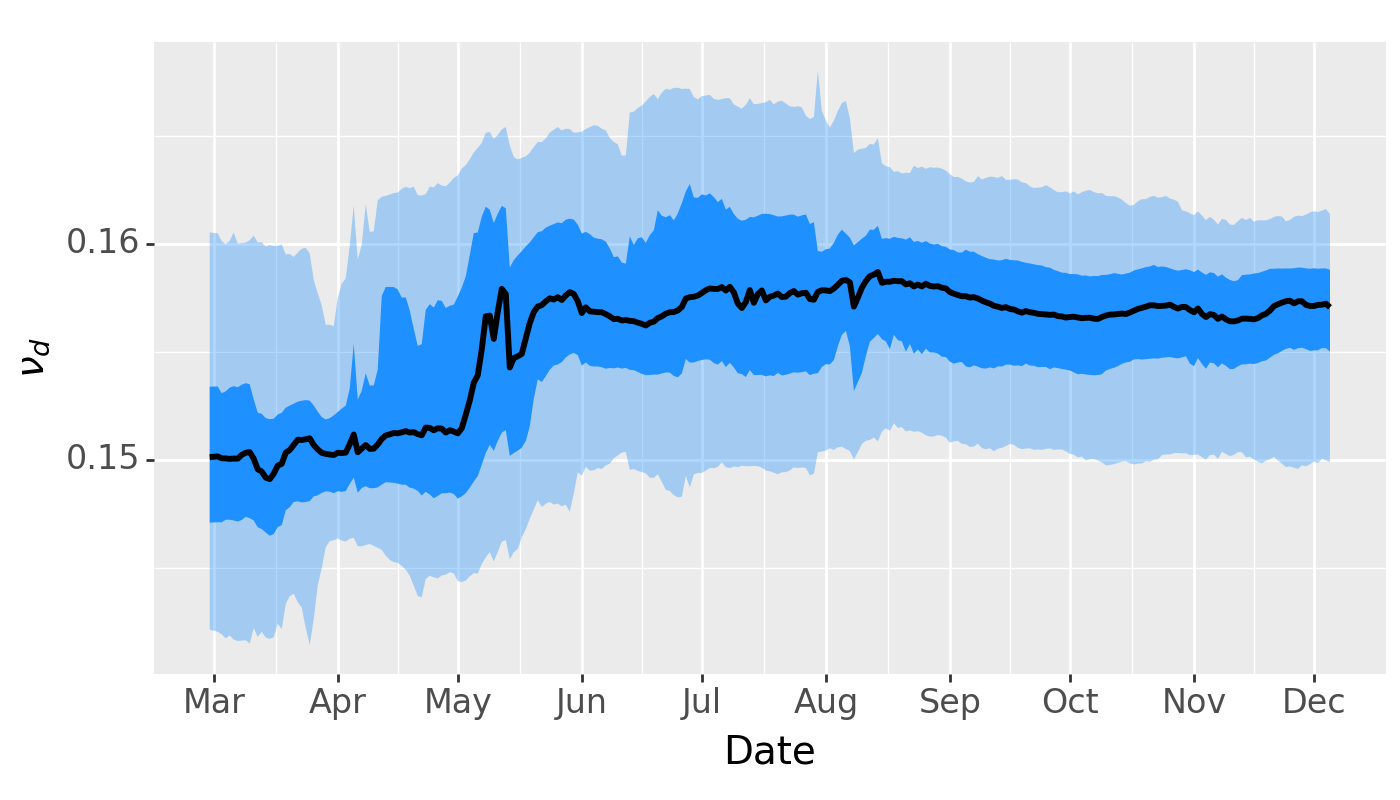


95 CI [0.14988736 0.16136689]
median 0.15705566016119743
mean 0.15672309481096927
std 0.0028444762636762196


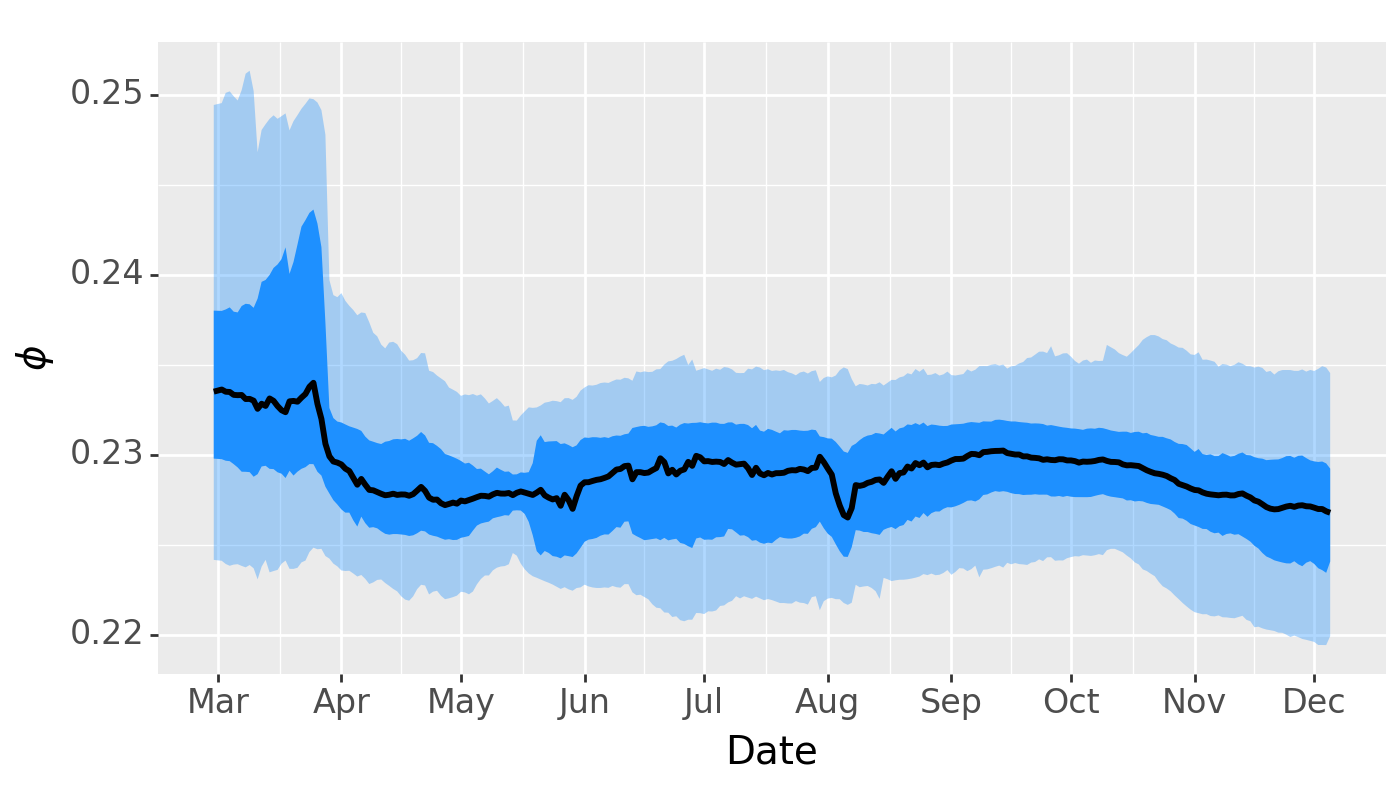


95 CI [0.21991672 0.23453297]
median 0.22677073337426495
mean 0.2267043842201725
std 0.0037740847020624442


In [9]:
trajParticles=results_filter['trajtheta']
matrix_dict=trace_smc(trajParticles)
num_states = len(matrix_dict)
L =[r'$\nu_{\beta}$',r'$\nu_{d}$', r'$\phi$']
# Create subplots. $D_t$ c


# Iterate through each key-value pair in matrix_dict and plot in a subplot
for i, (state, matrix) in enumerate(matrix_dict.items()):
    matrix=matrix[:,:days]

    date=d2['Date'][:days]
    if L[i]==r'$\nu_{\beta}$' or L[i]==r'$\nu_{d}$':
        matrix=np.sqrt(matrix)
    p =  plot_smc_covid(matrix,date) # use plot_smc(matrix, CI_50=False, CI_95=False) if you don't want the 50% or 95% CI to appear 
   
    # p += theme(figure_size=(10,4))
    # p+=scale_y_continuous(breaks=range(0.175, 0.2, 0.01))
    p+= ylab(L[i])
    p += xlab("Date")
    p += theme(figure_size=(7,4))
    print(p)
    print('95 CI',np.percentile(matrix[:,-1], [2.5, 97.5]))
    print('median', np.median(matrix[:,-1]))
    print('mean',np.mean(matrix[:,-1]))
    print('std',np.std(matrix[:,-1]))



#### Parameter density

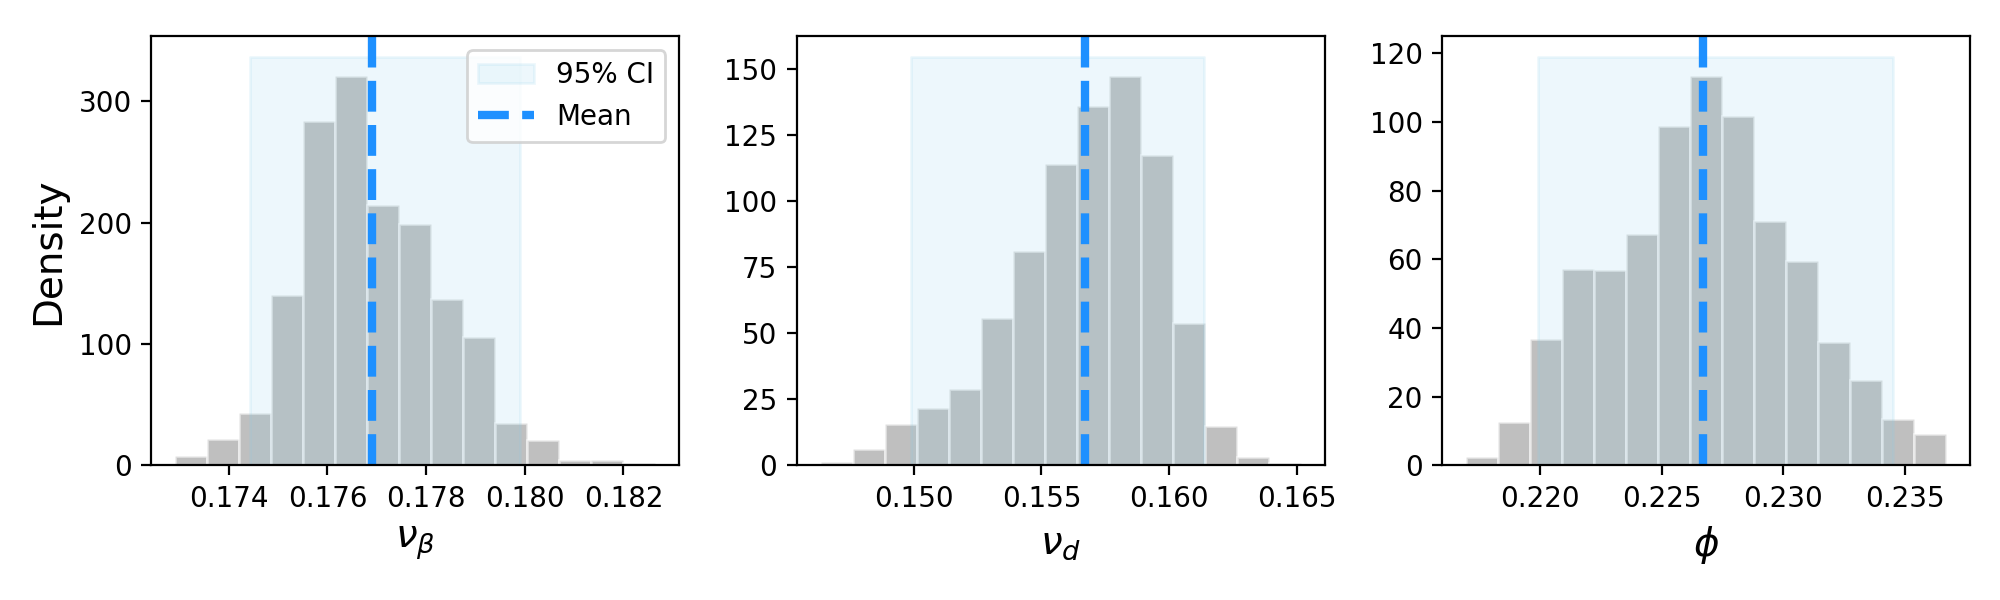

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.ticker import FuncFormatter  # Import the formatter


# Number of subplots needed
num_rows = 1
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3))  # 1 row, 4 columns of plots

# Flatten axes to iterate easily
axes = axes.flatten()
L =[r'$\nu_{\beta}$',r'$\nu_{d}$', r'$\phi$']
formatter = FuncFormatter(lambda x, _: f'{x:.3f}')

for i, (state, matrix) in enumerate(matrix_dict.items()):
    if L[i]==r'$\nu_{\beta}$' or L[i]==r'$\nu_{d}$':
        matrix=np.sqrt(matrix)
    matrix=matrix[:,:days]
    mean_value = np.mean(matrix[:, -1])
    data = matrix[:, -1]
    
    # Plot histogram
    axes[i].hist(data, bins=15, density=True, alpha=0.5, color='gray', edgecolor='white')
    
    # Compute and plot density using gaussian_kde
    kde = gaussian_kde(data, bw_method=0.3)
    x_vals = np.linspace(data.min()-0.01, data.max()+0.01, 1000)
    kde_vals = kde(x_vals)
    # axes[i].plot(x_vals, kde_vals, color='b', lw=1.5)
    
    # Calculate the 95% credible interval (2.5th and 97.5th percentiles)
    lower_bound, upper_bound = np.percentile(data, [2.5, 97.5])
    
    # Set y-limit to extend the shaded area to infinity (or ymax)
    ymax_hist = axes[i].get_ylim()[1]  # Get the current max y-limit of the axis
    
    # Fill the area between the 95% credible interval, extending the shading to ymax (infinity concept)
    axes[i].fill_between(x_vals, 0, ymax_hist, where=((x_vals >= lower_bound) & (x_vals <= upper_bound)), 
                         color='skyblue', alpha=0.15, label='95% CI')

    # Plot vertical line at mean_value
    axes[i].axvline(mean_value, color='dodgerblue', linestyle='dashed', lw=3, label='Mean')
    
   
    # Apply the formatter to the x-axis for rounding
    axes[i].xaxis.set_major_formatter(formatter)
    axes[i].set_xlabel(L[i], size=14)
    if i < 1:
        axes[i].set_ylabel('Density', size=14)
        axes[i].legend()
   

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()
